# Курсовой проект

- [Loading Data and Importing Libraries](#Loading-Data-and-Importing-Libraries)
- [EDA beginning](#EDA-beginning)
- [Train-test-split](#Train-test-split)
- [Baseline - Logistic Regression](#Baseline---Logistic-Regression)
- [Class Balancing + Ensemble Models](#Class-Balancing-+-Ensemble-Models)
- [EDA + Feature Selection](#EDA-+-Feature-Selection)
- [Final Model with hyperparameters](#Final-Model)

# Loading Data and Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import datetime as dt
import sys
import pickle


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix,\
                            log_loss, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score
from catboost import CatBoostClassifier


In [2]:
import warnings
warnings.filterwarnings("ignore")

Загрузим данные features.csv

In [3]:
%%time
features = pd.read_csv('features.csv', sep = '\t')

CPU times: user 2min 24s, sys: 16.3 s, total: 2min 41s
Wall time: 3min 14s


In [4]:
# features = dd.read_csv('features.csv', sep='\t')

In [5]:
features.head(2)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0


In [6]:
features.drop(columns='Unnamed: 0', inplace = True)

In [7]:
features['buy_time'] = features['buy_time'].apply(lambda date: dt.datetime.fromtimestamp(date))
features.head(1)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-16,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


Загрузим data_train.csv

In [8]:
data_train = pd.read_csv('data_train.csv')
data_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [9]:
data_train['buy_time'] = data_train['buy_time'].apply(lambda date: dt.datetime.fromtimestamp(date))

In [10]:
data_train.drop(columns='Unnamed: 0', inplace= True)

### Построим общий тренировочный датафрейм


In [11]:
# Используем метод merge_asof
# При использовании этого метода важно, чтобы датафеймы были отсортированы

features.sort_values('id', ascending = True, inplace = True)

In [12]:
data_train.sort_values('id', ascending = True, inplace = True)

In [14]:
%%time

df_train = pd.merge_asof(data_train,
                         features, 
                         on = 'id',
                         by='buy_time',
                         direction='nearest')
                         
df_train.head()

CPU times: user 18.2 s, sys: 14 s, total: 32.2 s
Wall time: 1min 25s


,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2,2.0,2018-12-24,0.0,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
1,4,1.0,2018-08-06,0.0,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,15,1.0,2018-08-13,0.0,49.150029,10.390888,63.159214,11.993202,57.741754,-9.11179,...,-950.373846,-593.770792,-24.996269,-37.630448,81.252276,-4.832889,-0.694428,8.824067,-0.45614,1.0
3,16,2.0,2018-10-29,0.0,42.570029,138.740888,28.629214,86.133202,23.211754,65.02821,...,1394.626154,1272.229208,-22.996269,-36.630448,-6.747724,-23.832889,-0.694428,-12.175933,-0.45614,0.0
4,29,1.0,2018-08-06,0.0,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [15]:
df_train.shape

(831653, 257)

In [16]:
# Сохраним на всякий случай полученный датасет
#df_train.to_csv('df_train_total.csv')

In [17]:
# df_train = pd.read_csv('df_train_total.csv')

# EDA beginning

**Target** - приобретена услуга или нет

In [18]:
df_train.target.value_counts(normalize = True)*100

0.0    92.763087
1.0     7.236913
Name: target, dtype: float64

0 класс количественно существенно преобладает над 1 классом.  
В дальнейшем имеет смысл попробовать потестировать балансировку классов

**Features**  

*Добавим дополнительные признаки на основе признака buy_time*

In [19]:
df_train['offer_year'] = df_train['buy_time'].dt.year
df_train['offer_month'] = df_train['buy_time'].dt.month
df_train['offer_day'] = df_train['buy_time'].dt.day
df_train['offer_weekday'] = df_train['buy_time'].dt.dayofweek
df_train['offer_hour'] = df_train['buy_time'].dt.hour
df_train.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,248,249,250,251,252,offer_year,offer_month,offer_day,offer_weekday,offer_hour
0,2,2.0,2018-12-24,0.0,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,...,11.167111,7.305572,-12.175933,-0.45614,0.0,2018,12,24,0,0
1,4,1.0,2018-08-06,0.0,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2018,8,6,0,0
2,15,1.0,2018-08-13,0.0,49.150029,10.390888,63.159214,11.993202,57.741754,-9.11179,...,-4.832889,-0.694428,8.824067,-0.45614,1.0,2018,8,13,0,0
3,16,2.0,2018-10-29,0.0,42.570029,138.740888,28.629214,86.133202,23.211754,65.02821,...,-23.832889,-0.694428,-12.175933,-0.45614,0.0,2018,10,29,0,0
4,29,1.0,2018-08-06,0.0,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2018,8,6,0,0


In [20]:
# Найдем количество уникальных значений

df_nunique = df_train.apply(lambda x: x.nunique(dropna=False))

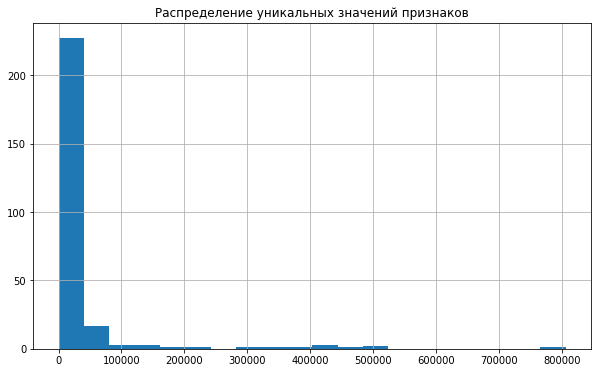

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Распределение уникальных значений признаков")
df_nunique.hist(bins=20)
plt.show()

Большинство признаков имеет относительно небольшое количество значений

In [22]:
# Определим общее количество признаков

f_all = set(df_nunique.index.tolist())
len(f_all)

262

In [23]:
# Проверим наличие КОНСТАНТЫХ признаков (принимающих единственное значение) - они бесполезны и при их наличии
# их необходимо удалить

f_const = set(df_nunique[df_nunique == 1].index.tolist())
len(f_const)

8

In [24]:
# Исключим константные признаки, они не имеют никакого значения в обучении модели и могут даже подпортить модель

f_all = f_all - f_const
len(f_all)

254

In [25]:
df_train.drop(columns = f_const, inplace = True)

**Рассмотрим, есть ли в текущем датасете пропуски**

In [26]:
for column in df_train.columns.tolist():
    if df_train[column].isnull().sum() != 0:
        print(column)

Отлично, в текущем обучаемом датасете нет пропусков, однако нельзя упускать возможность их наличия в тестовых датасетах, а значит важно учесть это при подготовке пайплайна

# Train-test-split

Датасет имеет временной признак, отвечающий за время подключения услуги, попробуем использовать **хронологический подход** для разделения датасета на выборки для обучения и валидации.


У нас есть дополнительные признаки, на основании которых можно более удобно изучить временной промежуток заданный в df_train

In [27]:
df_train.offer_month.min(), df_train.offer_month.max()

(7, 12)

In [28]:
df_train.loc[df_train.offer_month == 7, :].shape[0]

136679

In [29]:
total = 0
for month in range(df_train.offer_month.min(),df_train.offer_month.max()+1):
    num_objects = df_train.loc[df_train.offer_month == month, :].shape[0]
    percentage = round((num_objects/df_train.shape[0] * 100),2)
    print(f'Месяц {month} - {num_objects} - {percentage}%')
    
    # Проверка количества наблюдений, сумма должна совпасть
    total += df_train.loc[df_train.offer_month == month, :].shape[0]
print()
if total == df_train.shape[0]:
    print(f'Расчет корректен!')
else:
    print('Необходима перепроверка')


Месяц 7 - 136679 - 16.43%
Месяц 8 - 146804 - 17.65%
Месяц 9 - 112807 - 13.56%
Месяц 10 - 114263 - 13.74%
Месяц 11 - 73520 - 8.84%
Месяц 12 - 247580 - 29.77%

Расчет корректен!


На 12-й мес(декабрь) приходится около 30% всех объектов, примем его за валидационный период.  
Таким образом, будем обучаться на периоде с июля по ноябрь, а валидироваться на декабрьских наблюдениях.

In [30]:
VAL_MONTH = 12
RANDOM_STATE = 42

cols_to_drop = ['target', 'buy_time'] #сюда добавить признаки, которые не помогли в модели

y_train = df_train.loc[df_train['offer_month'] < VAL_MONTH, 'target']
X_train = df_train[df_train['offer_month'] < VAL_MONTH].drop(cols_to_drop, axis=1)

y_test = df_train.loc[df_train['offer_month'] >= VAL_MONTH, 'target']
X_test = df_train.loc[df_train['offer_month'] >= VAL_MONTH].drop(cols_to_drop, axis=1)


print("Train")
print(y_train.value_counts()/y_train.shape[0])
print("\nTest")
print(y_test.value_counts()/y_test.shape[0])

Train
0.0    0.934967
1.0    0.065033
Name: target, dtype: float64

Test
0.0    0.910324
1.0    0.089676
Name: target, dtype: float64


Получим baseline с тем, что есть, а потом проработаем дисбаланс классов и оценим его влияние на результат.

# Baseline - Logistic Regression

In [31]:
# Функция для обучения модели, получения предсказаний и вывода результатов на тренировочном и тестовом наборах данных

def evaluate_model(pipeline, X_train, y_train, X_test, y_test):

    pipeline.fit(X_train, y_train)
    
    y_pred_proba =  pipeline.predict_proba(X_test)[:, 1]
    
    # Построение графического представления результатов предсказаний для понимания порога
    plt.figure(figsize = (14,5))

    plt.plot(y_pred_proba[:150] , c = 'red', label = 'предсказания модели')
    plt.plot(y_test.values[:150], c = 'green', label = 'истиная классификация')

    plt.grid('on')
    plt.legend()
    plt.show()
    
    # Аналитический расчет порога классов
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    numerator = 2 * recall * precision
    denom = recall + precision
    f1score = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))

    # найдем порог, при котором достигается максимальное значение метрики f1_score
    ix = np.argmax(f1score)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            f1score[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    y_pred = np.where(y_pred_proba > thresholds[ix], 1, 0)
    
    print(f'f1_score macro_avg: {f1_score(y_test, y_pred, average = "macro")}')


Начнем с простого пайплайна, чтобы построить baseline. Далее будем его дорабатывать, в том числе используя понижение размерности, а также подбор гиперпараметров

In [32]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [33]:
columns = X_train.columns.tolist()

columns_prep_pipeline = make_pipeline(
    ColumnSelector(columns=columns),
    SimpleImputer(strategy="most_frequent"),
    StandardScaler()
)

Для baseline применим модель **Логистической регрессии**

In [34]:
step_log_reg = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)

In [35]:
baseline = make_pipeline(
    columns_prep_pipeline,
    step_log_reg
)

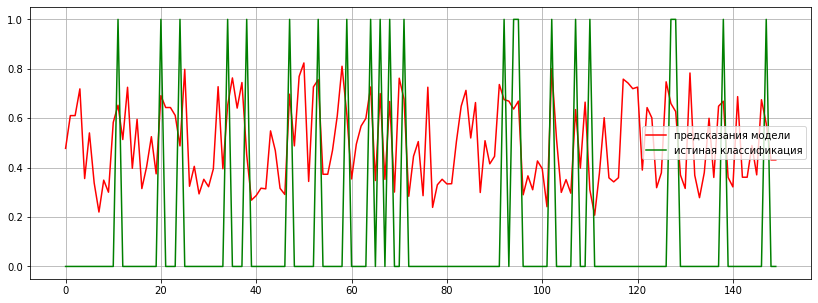

Best Threshold=0.514671, F-Score=0.315, Precision=0.211, Recall=0.623
f1_score macro_avg: 0.58399487808424
CPU times: user 8.68 s, sys: 9.73 s, total: 18.4 s
Wall time: 3min 40s


In [36]:
%%time
evaluate_model(baseline, X_train, y_train, X_test, y_test)

# Class Balancing + Ensemble Models

#### Балансировка классов

Ранее был выявлен сильный дисбаланс классов. Посмотрим, изменится ли метрика, если его обработать.
Сначала попробуем испрользовать oversampling. Однако, в результате такого метода датасет станет существенно больше, что усложнит и удлиннит работу модели, нужно будет попробовать понизить размерность.

In [37]:
def oversampling_by_target(df, target_name):
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [38]:
df_for_oversampling = pd.concat([X_train, y_train], axis=1)
df_oversampled = oversampling_by_target(df_for_oversampling, 'target')
    
df_oversampled.target.value_counts()

0.0    546089
1.0    531776
Name: target, dtype: int64

In [39]:
# Переопределение X_train, y_train

X_train = df_oversampled.drop(columns='target')
y_train = df_oversampled['target']

Сейчас классы примерно сбалансированы. Попробуем заново перезапустить baseline и посмотреть, будут ли улучшения метрики.

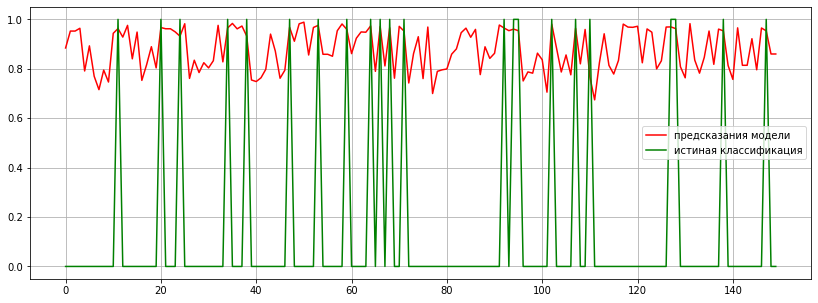

Best Threshold=0.917220, F-Score=0.352, Precision=0.225, Recall=0.806
f1_score macro_avg: 0.5920179939462257
CPU times: user 14.7 s, sys: 15.6 s, total: 30.3 s
Wall time: 10min 12s


In [40]:
%%time
evaluate_model(baseline, X_train, y_train, X_test, y_test)

Метрика немного выросла

**От идеи undersamopling-a отказалась, т. к. теряется довольно большое количество объектов**

In [41]:
# def undersampling_by_target(df, target_name):
    
#     target_counts = df[target_name].value_counts()

#     major_class_name = target_counts.argmax()
#     minor_class_name = target_counts.argmin()

#     df_ = df.copy()
#     df = df_[df_[target_name] == minor_class_name]
#     tmp = df_[df_[target_name] == major_class_name]
#     df = df.append(tmp.iloc[np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])], ignore_index=True)
        
#     return df.sample(frac=1) 

In [42]:
# df_train_undersampled = undersampling_by_target(df_train, 'target')

In [43]:
# df_train_undersampled.target.value_counts()

### Gradient Boosting Classifier

In [44]:
grb_pipeline = make_pipeline(
    columns_prep_pipeline,
    GradientBoostingClassifier(random_state=RANDOM_STATE, max_features=70))

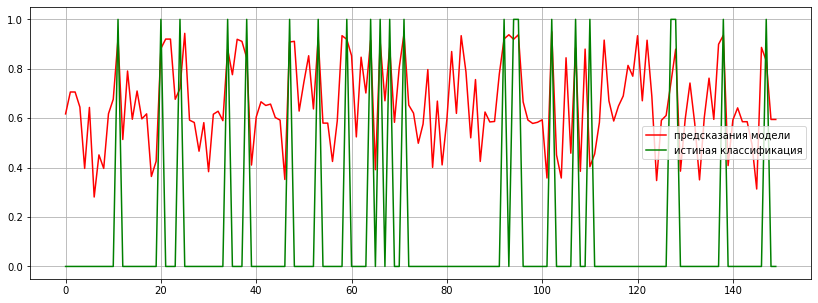

Best Threshold=0.801793, F-Score=0.505, Precision=0.388, Recall=0.722
f1_score macro_avg: 0.7158134936659103
CPU times: user 7min 24s, sys: 13.2 s, total: 7min 38s
Wall time: 7min 44s


In [45]:
%%time
evaluate_model(grb_pipeline, X_train, y_train, X_test, y_test)

### Catboost

In [46]:
ctb_pipeline = make_pipeline(
    columns_prep_pipeline,
    CatBoostClassifier(n_estimators = 500,
                       random_state=RANDOM_STATE, 
                       silent = True))

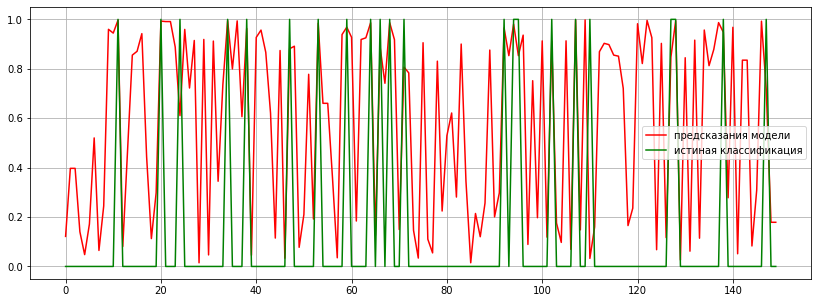

Best Threshold=0.943727, F-Score=0.405, Precision=0.362, Recall=0.459
f1_score macro_avg: 0.6686450566686075


In [47]:
evaluate_model(ctb_pipeline, X_train, y_train, X_test, y_test)

Итак,  
- наилучший результат на данный момент показала модель Gradient Boosting
- oversampling позволил повысить уровень метрики, однако обущающий датасет вырос и модель обучается очень долго.
- попробуем снизить размерность
- попробуем усовершенствовать пайплайн
- попробуем подобрать гиперпараметры

# EDA + Feature Selection

**Уберем признаки с 0 или очень низкой важностью в модели**

In [48]:
# не включила шаг SelectFromModel, т к очень модель долго обучается, 
# отобрала признаки вручную на основе их feature_importance

In [49]:
fi = pd.DataFrame(grb_pipeline.steps[1][1].feature_importances_, index=X_train.columns, columns=['importance'])
fi.sort_values(by='importance', ascending=False)

,importance
vas_id,0.505853
offer_month,0.277836
offer_day,0.103719
222,0.057643
id,0.018284
...,...
142,0.000000
143,0.000000
57,0.000000
145,0.000000


Довольно много признаков не имеют значимости для модели вообще (=0) или имеют ее очень низкую, они делают датасет объемнее, усложняя и удлинняя работу обучение модели. Уберем их, включив этот шаг в пайплайн

In [50]:
X_train.shape[1]

252

In [51]:
# Определим признаки с самой минимальной значимостью
not_imp_features = fi[fi['importance'] < 1e-4].index.tolist()
len(not_imp_features)

230

In [52]:
X_train1 = X_train.drop(columns = not_imp_features)

In [53]:
X_test1 = X_test.drop(columns = not_imp_features)

In [54]:
# Проверка, равное ли количество признаков 
X_train1.shape[1] == X_test1.shape[1]

True

In [55]:
print(f'Features num before selection: {X_train.shape[1]}')
print(f'Features num after seletion: {X_train1.shape[1]}')
print(f'Понизили размерность на {X_train.shape[1] - X_train1.shape[1]} фичей')
print(f'или на на {round((X_train.shape[1]-X_train1.shape[1])/X_train.shape[1] * 100, 2)}%')

Features num before selection: 252
Features num after seletion: 22
Понизили размерность на 230 фичей
или на на 91.27%


**Разделим признаки по типам**  
Ранее были удалены константные признаки

In [56]:
df_nunique = X_train1.apply(lambda x: x.nunique(dropna=False))

In [57]:
df_nunique.shape

(22,)

In [58]:
# Общее количество признаков

f_all = set(df_nunique.index.tolist())
len(f_all)

22

In [59]:
# БИНАРНЫЕ признаки

f_binary = set(df_nunique.loc[df_nunique == 2].index.tolist())
f_other = f_all - f_binary
len(f_binary)

3

In [60]:
# КАТЕГОРИАЛЬНЫЕ признаки

# Примем за категориальные признаки те, которые принимают менее 10 значений
f_categorical = set(df_nunique.loc[f_other][df_nunique.loc[f_other] <= 10].index.tolist())
f_other -= f_categorical
len(f_categorical)

2

In [61]:
# Остальные признаки примем за вещественные
f_numerical = f_other
len(f_numerical)

17

In [62]:
# Итого
print('Признаки по типам:')
print()
print(f'Бинарные  - {len(f_binary)}, \nКатегориальные - {len(f_categorical)}, \nВещественные - {len(f_numerical)}')

Признаки по типам:

Бинарные  - 3, 
Категориальные - 2, 
Вещественные - 17


In [63]:
f_cols = list(f_binary | f_categorical | f_numerical)
f_binary, f_categorical, f_numerical = list(f_binary), list(f_categorical), list(f_numerical)

In [65]:
f_cols

['134',
 'offer_month',
 'id',
 '224',
 '229',
 '144',
 '248',
 '14',
 'offer_day',
 '0',
 '13',
 'vas_id',
 '223',
 '192',
 '4',
 '250',
 '191',
 '2',
 '158',
 '222',
 '27',
 '201']

**Обновление pipeline**  
Обработаем признаки по-разному в зависимости от их типов

In [66]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numerical),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ]),
)

**Gradient Boosting**

In [67]:
grb_pipeline_upd = make_pipeline(
    f_prep_pipeline,
#     SelectFromModel(GradientBoostingClassifier(max_features=70, random_state=RANDOM_STATE), threshold=1e-5),
    GradientBoostingClassifier(random_state=RANDOM_STATE, max_features = 15)
)

# не включила шаг SelectFromModel, т к очень долго обучается, сделала его вручную отобрав признаки по величине
# feature_importance

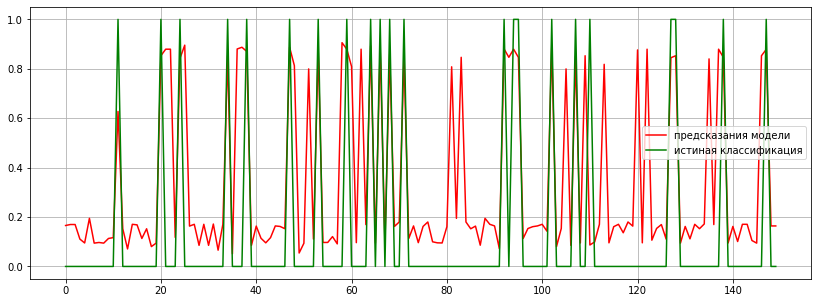

Best Threshold=0.783144, F-Score=0.576, Precision=0.417, Recall=0.932
f1_score macro_avg: 0.7519921842865241
CPU times: user 2min 21s, sys: 1.3 s, total: 2min 22s
Wall time: 2min 23s


In [68]:
%%time
evaluate_model(grb_pipeline_upd, X_train1, y_train, X_test1, y_test)

**Catboost**

In [69]:
ctb_pipeline_upd = make_pipeline(
    f_prep_pipeline,
#     SelectFromModel(GradientBoostingClassifier(max_features=70, random_state=RANDOM_STATE), threshold=1e-5),
    CatBoostClassifier(n_estimators = 500,
                       random_state=RANDOM_STATE, 
                       silent = True))

# не включила шаг SelectFromModel, т к очень долго обучается, сделала его вручную отобрав признаки по величине
# feature_importance

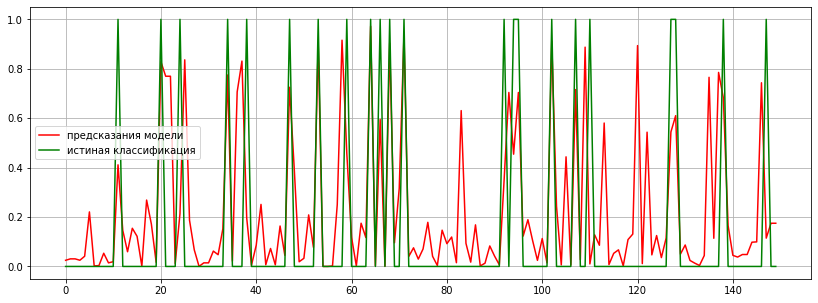

Best Threshold=0.386333, F-Score=0.553, Precision=0.400, Recall=0.893
f1_score macro_avg: 0.7384070438294734
CPU times: user 4min 19s, sys: 42.1 s, total: 5min 1s
Wall time: 51.9 s


In [70]:
%%time
evaluate_model(ctb_pipeline_upd, X_train1, y_train, X_test1, y_test)

Снова наблюдается рост метрики, а также заметное сокращение времени обучения модели.На графике скоров видно довольно явное разделение на классы. Наилучший результат достигнут у модели Gradient Boosting
С учетом сократившегося количества признаков, можно будет загружать датафрейм features сразу с мЕньшим количеством признаков, обеспечивая более быстрое получения результата.

# Final Model

#### Подбор гиперпараметров к Gradient Boosting  
  
*Поиск по сетке закомментирован для ускорения работы ноутбука

In [71]:
# grb_pipeline_upd.get_params().keys()

In [72]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [73]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1_macro'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [74]:
# param_grid = {
#     'gradientboostingclassifier__max_features': [10, 15],
#     'gradientboostingclassifier__max_depth': [5, 7],  - глубина ухудшила метрику!
#     'gradientboostingclassifier__n_estimators': [50, 70, 90],
# }

# lg_gsc = run_grid_search(grb_pipeline_upd, X_train, y_train, param_grid, kfold_cv)

**Best parameters set found on development set:**

{'gradientboostingclassifier__max_max_features': 15, 'gradientboostingclassifier__n_estimators': 90}

In [86]:
grb_pipeline_gs = make_pipeline(
    f_prep_pipeline,
    GradientBoostingClassifier(random_state=RANDOM_STATE, max_features=15, n_estimators = 90))

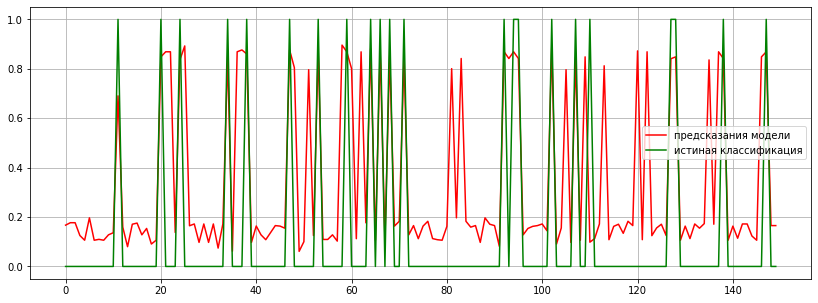

Best Threshold=0.783505, F-Score=0.576, Precision=0.420, Recall=0.917
f1_score macro_avg: 0.7525557429904701


In [87]:
evaluate_model(grb_pipeline_gs, X_train1, y_train, X_test1, y_test)

**Проверка на кросс валидации**

In [88]:
cv_scores = cross_val_score(grb_pipeline_gs, X_train1, y_train, cv=7, scoring='f1_macro')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.8710437852551032+-0.0007633881929540837


In [89]:
cv_scores

array([0.87010975, 0.87170308, 0.87212544, 0.8700518 , 0.8705261 ,
       0.87162241, 0.87116792])

**Сохраним финальную модель**

In [90]:
final_pipeline = grb_pipeline_gs

In [91]:
with open('model.pkl', 'wb') as f:
	pickle.dump(final_pipeline, f)

### Predicitons on test dataset

**Скрипт содержится в script.py**

In [92]:
data_test = pd.read_csv('data_test.csv')
data_test.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [106]:
features_columns = ['id', 'buy_time', '158', '0', '2', '144', '27', '250', '13', '229', '223', '4',
                   '14', '224', '191', '222', '248', '201', '134', '192']

In [107]:
features_df = pd.read_csv('features.csv', sep = '\t', usecols = features_columns)

In [108]:
features_df.head(2)

,id,buy_time,0,2,4,13,14,27,134,144,158,191,192,201,222,223,224,229,248,250
0,2013026,1531688400,18.910029,4.969214,3.791754,49.520873,38.19189,-0.00909,-190.670372,-70.470802,-0.536315,-109.036398,0.533317,0.895335,9.595373e+08,-42.014078,-4.405604e+08,-249.128986,-25.832889,-12.175933
1,2014722,1539550800,36.690029,448.069214,463.841754,67.300873,55.97189,-0.00909,-190.670372,57.495858,-0.536315,-109.036398,-0.466683,-0.104665,9.673997e+08,-39.474078,1.033869e+09,38.871014,-13.832889,-1.175933


In [109]:
def transform(df1, df2, col1, col2):
    # Удаление признака, признанного за ненужный:
    df1.drop(columns='Unnamed: 0', inplace=True)

    # Преобразование признака времени
    df1[col2] = df1[col2].apply(lambda x: dt.datetime.fromtimestamp(x))
    df2[col2] = df2[col2].apply(lambda x: dt.datetime.fromtimestamp(x))

    # присоединение датасета features - df2
    df1.sort_values(col1, ascending= True, inplace=True)
    df2.sort_values(col1, ascending= True, inplace=True)

    df = pd.merge_asof(df1,
                       df2,
                       on= col1,
                       by= col2,
                       direction='nearest')

    # Создание новых признаков
    df['offer_month'] = df[col2].dt.month
    df['offer_day'] = df[col2].dt.day

    # Удаление признака buy_tine
    df.drop(columns= col2, inplace=True)

    return df

In [110]:
df_test = transform(data_test, features_df, 'id', 'buy_time')

In [111]:
# Перепроверим, совпадает ли по количетсву колонок преобразованный датасет с тем, на котором обучались

df_test.shape[1] == X_train1.shape[1]

True

In [112]:
# Проверим, совпадают ли столбцы с тренировочным датасетом

df_test.columns == X_train1.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [113]:
# df_test['target'] = final_pipeline.predict_proba(df_test)[:, 1]

In [88]:
# df_test['target'].to_csv('AleksandrinaViatkina_MegaforPreds.csv')